## Imports & Setup

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, RandomAdjustSharpness, Grayscale, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.AutoEncoder import *
from architecture.Transformer import *

In [3]:
torch.manual_seed(109)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

## Prepare Dataset

In [4]:
size = 32
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), Grayscale(1),
                          RandomAdjustSharpness(2, p=1),
                          ToTensor(), Normalize(mean=[0.4814], std=[0.2136])])

In [5]:
root = 'chest_xray/train'
train_data = create_dataset(root, transformation)
train_loader = produce_loader(train_data, batch_size, shuffle=True)

In [6]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [7]:
root = 'chest_xray/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

## Testing Transformer (20 epochs)

Here, we load the Transformer model that was trained for 20 epochs and verify that its performance is reproducible.

In [8]:
from math import floor
# number of convolutional 'embedding' layers and their sizes
hidden = [1, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]

In [8]:
transformer = Transformer(hidden, kernel_size, window, blocks).to(device)
transformer.load_state_dict(torch.load('./Transformer_20epochs')["model_state_dict"])
for param in transformer.parameters():
    param.requiresGrad = False

Test loss: 0.3070, Test accuracy: 0.8855
Precision: 0.8781512605042017
Recall: 0.9789227166276346
F1 score: 0.9258028792912514


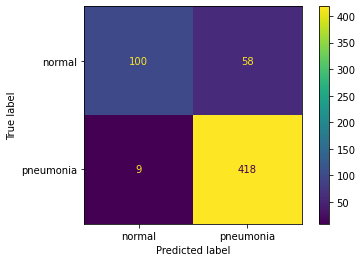

In [9]:
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=transformer, 
                                                          data_loader=test_loader, get_predictions=True)
show_metrics(true_labels=true_labels, model_preds=model_preds)

## Further Training of Transformer

Since training was not stopped early for the full 20 epochs, continue training the Transformer to verify if the performance can improve further.

In [10]:
for param in transformer.parameters():
    param.requiresGrad = True

In [14]:
optimizer = create_adam_optimizer(transformer, lr = 0.001)
optimizer.load_state_dict(torch.load('./Transformer_20epochs')["optimizer_state_dict"])

In [15]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [17]:
# continue training from 20 epochs to see if performance improves further
tl, ta, vl, va = train(device, transformer,
                       train_loader, val_loader, 
                       optimizer, epochs = 20)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.8046875
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.8333333333333334
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.828125
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.82275390625
Epoch 1/20, Batch number: 20, Cumulated accuracy: 0.8251488095238095
Epoch 1/20, Batch number: 25, Cumulated accuracy: 0.8257211538461539
Epoch 1/20, Batch number: 30, Cumulated accuracy: 0.8228326612903226
Epoch 1/20, Batch number: 35, Cumulated accuracy: 0.8213975694444444
Epoch 1/20, Batch number: 40, Cumulated accuracy: 0.8206935975609756
Epoch 1/20, Batch number: 45, Cumulated accuracy: 0.8186141304347826
--- Epoch 1/20: Train loss: 0.4104, Train accuracy: 0.8189
--- Epoch 1/20: Val loss: 0.2563, Val accuracy: 0.9350
Epoch 2/20, Batch number: 0, Cumulated accuracy: 0.8125
Epoch 2/20, Batch number: 5, Cumulated accuracy: 0.80859375
Epoch 2/20, Batch number: 10, Cumulated accuracy: 0.8075284090909091
Epoch 2/20, Batch number: 15, Cumulat

Test loss: 0.2682, Test accuracy: 0.9128
Precision: 0.9122807017543859
Recall: 0.9742388758782201
F1 score: 0.942242355605889


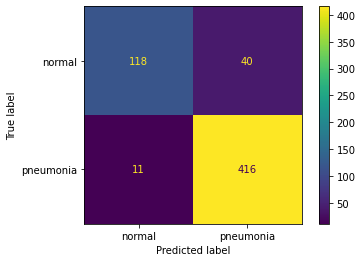

In [18]:
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=transformer, 
                                                          data_loader=test_loader, get_predictions=True)
show_metrics(true_labels=true_labels, model_preds=model_preds)

## Testing Transformer Checkpoint (26 epochs)

Here, we load the checkpoint with the lowest validation loss at 6 epochs before training was stopped at 9 epochs and check its performance. Note that this model was thus trained for 26 epochs in total.

In [16]:
transformer.load_state_dict(torch.load('./Transformer_checkpoint')["model_state_dict"])
for param in transformer.parameters():
    param.requiresGrad = False

Test loss: 0.2814, Test accuracy: 0.9077
Precision: 0.9010752688172043
Recall: 0.9812646370023419
F1 score: 0.9394618834080717


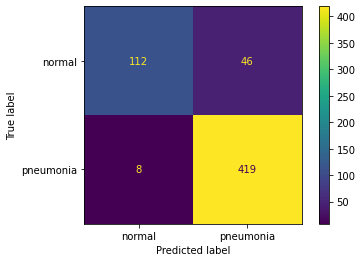

In [19]:
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=transformer, 
                                                          data_loader=test_loader, get_predictions=True)
show_metrics(true_labels=true_labels, model_preds=model_preds)

## Initialise Autoencoder

In [20]:
# number of hidden layers and their sizes
hidden_a = [1, 32, 64, 128, 256]

# kernel size of convolution layers
kernel_size_a = 3

In [21]:
autoencmodel = AutoEncoder(hidden_a, kernel_size_a).to(device)
autoencmodel.load_state_dict(torch.load("./autoencoder256_4epochs")["model_state_dict"])
for param in autoencmodel.parameters():
    param.requiresGrad = False

## Transformer with Autoencoder

Here, we load the Transformer model that was trained with the autoencoder's features for 20 epochs and verify that its performance is reproducible.

In [29]:
from math import floor
# number of hidden layers and their sizes
hidden = [256, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
channels = hidden[-1]
changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]

In [30]:
transformer = Transformer(hidden, kernel_size, window, blocks).to(device)
transformer.load_state_dict(torch.load('./Transformer_20epochs_withAE')["model_state_dict"])
for param in transformer.parameters():
    param.requiresGrad = False

Test loss: 0.3201, Test accuracy: 0.8803
Precision: 0.8905908096280087
Recall: 0.9531615925058547
F1 score: 0.9208144796380091


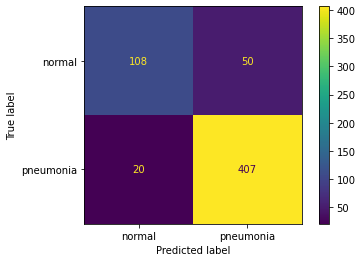

In [31]:
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=transformer, 
                                                          data_loader=test_loader, autoencoder=autoencmodel,
                                                          get_predictions=True)
show_metrics(true_labels=true_labels, model_preds=model_preds)

## Further Training of Transformer with Autoencoder

Since training was not stopped early for the full 20 epochs, continue training the Transformer to verify if the performance can improve further.

In [32]:
for param in transformer.parameters():
    param.requiresGrad = True

In [33]:
optimizer = create_adam_optimizer(transformer, lr = 0.001)
optimizer.load_state_dict(torch.load('./Transformer_20epochs_withAE')["optimizer_state_dict"])

In [34]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [36]:
# continue training from 20 epochs to see if performance improves further
tl, ta, vl, va = train(device, transformer,
                       train_loader, val_loader, 
                       optimizer, autoencoder=autoencmodel, epochs = 20)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.796875
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.8255208333333334
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.8061079545454546
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.8037109375
Epoch 1/20, Batch number: 20, Cumulated accuracy: 0.8035714285714286
Epoch 1/20, Batch number: 25, Cumulated accuracy: 0.8073918269230769
Epoch 1/20, Batch number: 30, Cumulated accuracy: 0.8044354838709677
Epoch 1/20, Batch number: 35, Cumulated accuracy: 0.8049045138888888
Epoch 1/20, Batch number: 40, Cumulated accuracy: 0.8027820121951219
Epoch 1/20, Batch number: 45, Cumulated accuracy: 0.8050271739130435
--- Epoch 1/20: Train loss: 0.4277, Train accuracy: 0.8051
--- Epoch 1/20: Val loss: 0.3098, Val accuracy: 0.8957
Epoch 2/20, Batch number: 0, Cumulated accuracy: 0.7890625
Epoch 2/20, Batch number: 5, Cumulated accuracy: 0.8059895833333334
Epoch 2/20, Batch number: 10, Cumulated accuracy: 0.8103693181818182
Epoch 2/20, Batch 

Test loss: 0.2833, Test accuracy: 0.9043
Precision: 0.9244851258581236
Recall: 0.9461358313817331
F1 score: 0.9351851851851851


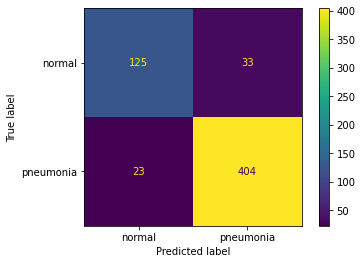

In [38]:
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=transformer, 
                                                          data_loader=test_loader, get_predictions=True,
                                                          autoencoder=autoencmodel)
show_metrics(true_labels=true_labels, model_preds=model_preds)

In [40]:
torch.save({'model_state_dict': transformer.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict()}, 
           './Transformer_29epochs_withAE')

## Testing Transformer with Autoencoder Checkpoint (26 epochs)

Here, we load the checkpoint with the lowest validation loss at 6 epochs before training was stopped at 9 epochs and check its performance. Note that this model was thus trained for 26 epochs in total.

In [41]:
transformer.load_state_dict(torch.load('./Transformer_checkpoint_withAE')["model_state_dict"])
for param in transformer.parameters():
    param.requiresGrad = False

Test loss: 0.2975, Test accuracy: 0.9009
Precision: 0.9072847682119205
Recall: 0.9625292740046838
F1 score: 0.934090909090909


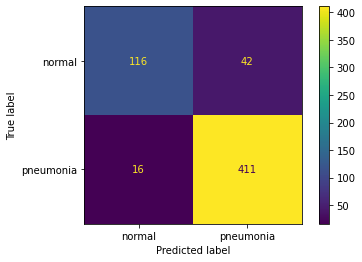

In [47]:
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=transformer, 
                                                          data_loader=test_loader, get_predictions=True,
                                                          autoencoder=autoencmodel)
show_metrics(true_labels=true_labels, model_preds=model_preds)